In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import math

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [45]:
df = pd.read_csv('diabetes.csv')

df[list(df.columns)[:-1]] = df[list(df.columns)[:-1]].replace(0, np.NaN)
df[list(df.columns)[:-1]] = pd.DataFrame(IterativeImputer(max_iter=100, random_state=0)
                                         .fit_transform(df[list(df.columns)[:-1]]), columns=df[list(df.columns)[:-1]].columns)

index = 1
features = list(df.columns)[:-1]
for feature1 in features:
    for feature2 in features:
        if feature1 != feature2:
            df[f'F{index}'] = df[feature1] * df[feature2]
            df[f'F{index+1}'] = df[feature1] / df[feature2]
            index += 2

df.loc[:,'N1']=0
df.loc[(df['Age']<=30) & (df['Glucose']<=120),'N1']=1
df.loc[:,'N2']=0
df.loc[(df['BMI']<=30),'N2']=1
df.loc[:,'N3']=0
df.loc[(df['Age']<=30) & (df['Pregnancies']<=6),'N3']=1
df.loc[:,'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=1
df.loc[:,'N5']=0
df.loc[(df['SkinThickness']<=20) ,'N5']=1
df.loc[:,'N6']=0
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=1
df.loc[:,'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=1
df.loc[:,'N9']=0
df.loc[(df['Insulin']<200),'N9']=1
df.loc[:,'N10']=0
df.loc[(df['BloodPressure']<80),'N10']=1
df.loc[:,'N11']=0
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N11']=1
    
high_corr = df.corr()[abs(df.corr())>=.9]
del_cols = []
for row in range(len(high_corr)):
    for col in range(len(high_corr)):
        if row != col and not math.isnan(high_corr.iloc[row, col]):
            del_cols.append(row)
del_cols = list(set(del_cols))
del_cols = [list(df.columns)[i] for i in del_cols]
df = df.drop(columns=list(set(del_cols)))

X = df.drop(columns=['Outcome'])
y = df['Outcome']

scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(scaled,columns=X.columns)

X

,Glucose,BloodPressure,BMI,F2,F6,F8,F12,F14,F20,F26,...,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11
0,0.865673,-0.029828,0.167923,0.114266,0.075700,-0.234291,-0.306076,-0.108757,-0.218354,-0.561273,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,-1.861482,0.609449,-1.031754
1,-1.203506,-0.524085,-0.850370,-0.926240,-1.014180,-0.478410,-0.775792,-1.379022,-0.882523,-0.537655,...,-0.736321,1.269742,-1.072968,1.534181,-0.486534,-0.430331,2.268039,0.537206,0.609449,0.969223
2,2.015217,-0.688837,-1.330422,0.229082,1.704323,-0.179526,-0.142847,1.773290,2.020562,-0.421290,...,-0.736321,1.269742,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,-1.861482,0.609449,-1.031754
3,-1.072129,-0.524085,-0.632164,-0.945359,-0.942589,-0.539075,-0.556392,-1.156637,-0.402118,0.584352,...,1.358103,1.269742,0.931994,1.534181,-0.486534,-0.430331,2.268039,0.537206,0.609449,0.969223
4,0.504388,-2.665865,1.549893,-0.235534,-0.327062,-0.272491,-0.845741,0.009133,-0.379227,-1.241059,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.678000,0.299676,0.066094,2.228462,0.369406,0.284878,3.112461,0.451950,-1.305771,0.807038,...,-0.736321,-0.787562,-1.072968,1.534181,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
764,0.011726,-0.194580,0.633429,-0.758870,-0.699093,-0.505931,-0.563778,-0.773640,-0.069939,-0.087499,...,-0.736321,-0.787562,0.931994,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,0.969223
765,-0.021118,-0.029828,-0.908558,0.142534,0.441493,0.084697,0.451492,0.566849,0.310048,0.433642,...,-0.736321,1.269742,0.931994,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
766,0.143103,-1.018342,-0.341223,-1.064664,-1.006409,-0.631185,-0.774651,-1.538004,-0.095872,-0.078979,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,0.969223


In [46]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# model = DecisionTreeClassifier(min_samples_split=2,
#                                max_depth=4,
#                                criterion='entropy')
model = LogisticRegression(max_iter=1000,
                           tol=1e-5, 
                           solver='saga')

scores = []
for train_index , test_index in kfold.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    # X_train, y_train = SMOTE(random_state=0).fit_resample(X_train, y_train)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    # plt.show()
    scores.append(accuracy_score(y_test, y_pred) * 100)

np.mean(scores), np.std(scores)

(76.95488721804512, 3.817417209455358)

LR: 0.770830 (0.036047)
LDA: 0.770830 (0.044130)
KNN: 0.722608 (0.049676)
CART: 0.705759 (0.050198)
NB: 0.723975 (0.041889)
SVM: 0.747403 (0.060734)


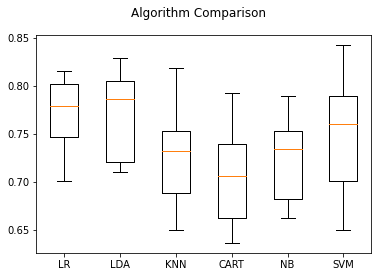

In [32]:
models = []
models.append(('LR', LogisticRegression(max_iter =1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(max_iter =1000)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [21]:
param = {'penalty': ['l1', 'l2', 'elasticnet'],
         'tol': [1e-4, 1e-5, 1e-6],
         'C': [0.01, 0.1, 1, 10],
         'class_weight': [None, 'balanced'],
         'solver': ['netwon-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

clf = RandomizedSearchCV(LogisticRegression(random_state=0, max_iter=10000), param, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=0)
search = clf.fit(X, y)
search.best_params_

C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
285 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

------------------------------------------------------------

{'tol': 1e-06,
 'solver': 'sag',
 'penalty': 'l2',
 'class_weight': None,
 'C': 0.01}